<a href="https://colab.research.google.com/github/DeependraChaddha/Heat_Equation_Solver/blob/main/Heat_Equation_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Using Gradient Descent to solve heat equation.
The difference between LHS and RHS of Heat Equation is used as Loss function.
Will experiment with optimizers to see which works best

#Make imports

In [ ]:
import torch
from torch import nn
import numpy as np
import random
from torch import Tensor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import time
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image

#Device-Agnostic Code

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

Set random seeds

In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch CUDA (Single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA (All GPUs)

    # Ensures deterministic behavior in GPU operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Can slow down training but ensures reproducibility

# Call this at the beginning of your script
set_seed(42)

#Specifying equation and coordinate system

Will figure out how to solve for first example, will then functionalize and implement on example 2 and 3. Example 4 is time dependent so may have to use different approach for that

##Example 1
∂²T/∂x² + ∂²T/∂y² = 8π²sin(2πx)sin(2πy)

T(0,y) = 0
T(1,y) = 0
T(x,0) = 0
T(x,1) = 0


Take x=0,x=1, y=0,y=1 as edges because of the initial conditions

In [ ]:
#Specify number of points in grid in each direction
#todo assert both nx,ny to be strictly greater than 1 when generalizing
nx=1000
ny=1000

#calculate spacing between 2 points in the grid
lx=1/(nx-1)
ly=1/(ny-1)

Make grid

In [ ]:
#Make linear space of x and y and reshape to the shape(nx,1) and (ny,1) respectively (Reshaping is done so that in case of matrix multiplication or broadcasting no error is encountered)
x=torch.linspace(0,1,nx).reshape(-1,1).requires_grad_(True)
y=torch.linspace(0,1,ny).reshape(-1,1).requires_grad_(True)

#Make meshgrid
X,Y=torch.meshgrid(x.squeeze(),y.squeeze(),indexing='ij')
X.reshape(-1,1).requires_grad_(True)
Y.reshape(-1,1).requires_grad_(True)
print(X.shape)
print(Y.shape)

torch.Size([1000, 1000])
torch.Size([1000, 1000])


In [ ]:
#To get (i,j) point
i=3
j=4
print(f'(i,j)th point is {X[i,j]},{Y[i,j]}')

(i,j)th point is 0.0030030030757188797,0.004004003945738077


###Make PINN to find solution of Heat Equation







In [ ]:
class SolutionFunction(nn.Module):
  def __init__(self):
    set_seed()
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(2,10),
        nn.Tanh(),
        nn.Linear(10,10),
        nn.Tanh(),
        nn.Linear(10,10),
        nn.Tanh(),
        nn.Linear(10,1)
    )

  def forward(self,X,Y,nx,ny):
      #reshape before concatenation to get correct dimension
      X=X.reshape(-1,1)
      Y=Y.reshape(-1,1)
      return self.layers(torch.cat((X,Y),dim=1)).reshape(nx,ny)

#check if it works properly
demo_model=SolutionFunction()
demo_model(X,Y,nx,ny)

tensor([[0.3230, 0.3229, 0.3228,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3229, 0.3229,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3230, 0.3229,  ..., 0.2529, 0.2528, 0.2527],
        ...,
        [0.3587, 0.3586, 0.3585,  ..., 0.2845, 0.2844, 0.2843],
        [0.3587, 0.3586, 0.3586,  ..., 0.2845, 0.2844, 0.2844],
        [0.3588, 0.3587, 0.3586,  ..., 0.2845, 0.2845, 0.2844]],
       grad_fn=<ViewBackward0>)

In [ ]:
demo_model(X,Y,nx,ny).shape[-1]

1000

Constructing loss functions

In [ ]:
def pde_loss(model:nn.Module,
             x:torch.Tensor,
             y:torch.Tensor,
             nx:int,
             ny:int):
  '''
  calculates loss according to the heat equation
  Inputs:
  Model:the neural network being trained
  x,y: x,y direction coordinates of meshgrid

  Output: Value of loss according to heat equation
  '''

  x.requires_grad_(True)
  y.requires_grad_(True)

  #calculate meshgrid
  f=model(x,y,nx,ny)

  #Calculate gradients
  f_x=torch.autograd.grad(f,x,torch.ones_like(f),create_graph=True)[0]
  f_y=torch.autograd.grad(f,y,torch.ones_like(f),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=8*np.pi**2*torch.sin(2*np.pi*x)*torch.sin(2*np.pi*y)

  #Calculate loss
  loss=torch.mean((f_xx+f_yy-target)**2)

  return loss




def boundary_loss(model:nn.Module,
                  x:torch.Tensor,
                  y:torch.Tensor,
                  nx:int,
                  ny:int):
  ''' Input: the gird coordinates and model
      Output:Boundary Loss Value
      loss is defined for a specific boundary condition will have to change function depending on the problem, it is NOT a generally usable function
  '''
  x.requires_grad_(True)
  y.requires_grad_(True)

  #calculate meshgrid
  f=model(x,y,nx,ny)

  #get loss
  loss=(f[0,:]-torch.zeros(f.shape[-1]))**2+ (f[-1,:]-torch.zeros(f.shape[-1]))**2+ (f[:,0]-torch.zeros(f.shape[-1]))**2+ (f[:,-1]-torch.zeros(f.shape[-1]))**2

  # return loss
  return torch.mean(loss)






def total_loss(model:nn.Module,
               x:torch.Tensor,
               y:torch.Tensor,
               nx:int,
               ny:int,
               boundary_loss_weight:float=100.0):
  '''Combining both loss functions using a specific weight to measure relative importance of the 2 losses'''
  return pde_loss(model,x,y,nx,ny)+boundary_loss_weight*boundary_loss(model,x,y,nx,ny)

test loss function

In [ ]:
loss=total_loss(demo_model,X,Y,nx,ny)
print(loss)

tensor(1592.7068, grad_fn=<AddBackward0>)


Set Optimizer and Train


In [ ]:
#Try plotting after every few steps to visualize the training process
#Initialize Model
model=SolutionFunction()
print(model(X,Y,nx,ny))
#Set SGD Optimizer
sgd_optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

#Set ADAM Optimizer
adam_optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

tensor([[0.3230, 0.3229, 0.3228,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3229, 0.3229,  ..., 0.2528, 0.2528, 0.2527],
        [0.3230, 0.3230, 0.3229,  ..., 0.2529, 0.2528, 0.2527],
        ...,
        [0.3587, 0.3586, 0.3585,  ..., 0.2845, 0.2844, 0.2843],
        [0.3587, 0.3586, 0.3586,  ..., 0.2845, 0.2844, 0.2844],
        [0.3588, 0.3587, 0.3586,  ..., 0.2845, 0.2845, 0.2844]],
       grad_fn=<ViewBackward0>)


Make a plotting function to visualize training

In [ ]:
def plot_solution(frames:list):

  #Animate collected frames
  def update(frame_idx):
    X_np, Y_np, Z_np, epoch=frames[frame_idx]
    ax.clear()
    ax.plot_surface(X_np, Y_np, Z_np, cmap='viridis')
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("T")
    ax.set_title(f"Epoch: {epoch+1}")
  #Create Animation
  ani=FuncAnimation(fig, update,frames=len(frames),interval=500)

  return ani

Make Training Loop

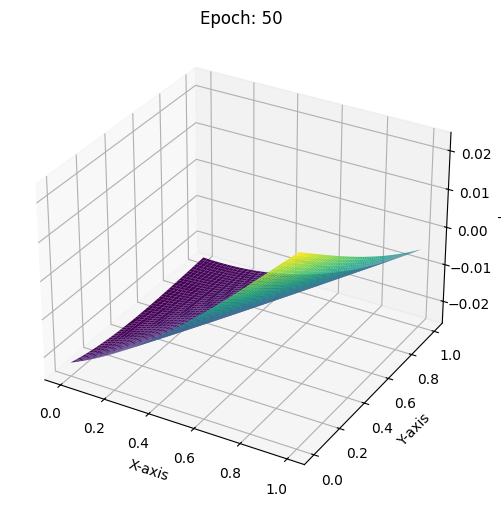

In [ ]:
# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

epochs=50
frames=[]
loss_values=[]

#disable interactive mode before training
plt.ioff()

for epoch in range(epochs):
  #Send data to selected device
  X.to(device)
  Y.to(device)


  #Forward Pass
  prediction=model(X,Y,nx,ny)

  #Calculate Loss
  loss=total_loss(model=model,x=X,y=Y, nx=nx,ny=ny, boundary_loss_weight=100.0)
  loss_values.append(loss.item())

  #Set Optimizer Zero Grad
  sgd_optimizer.zero_grad()

  #Backward pass
  loss.backward()

  #Optimizer Step
  adam_optimizer.step()

  # Convert tensors to NumPy for plotting
  X_np, Y_np, Z_np = X, Y, prediction #copy is used so that the stored values done get updated in each epoch

  #Store plot frame
  frames.append((X_np.detach().cpu().numpy().copy(), Y_np.detach().cpu().numpy().copy(), Z_np.detach().cpu().numpy().copy(), epoch))


ani=plot_solution(frames)

# **Optional: Save animation as a GIF**
ani.save("training_animation.gif", writer="pillow", fps=2)  # Saves at 2 FPS

Plot Loss curve

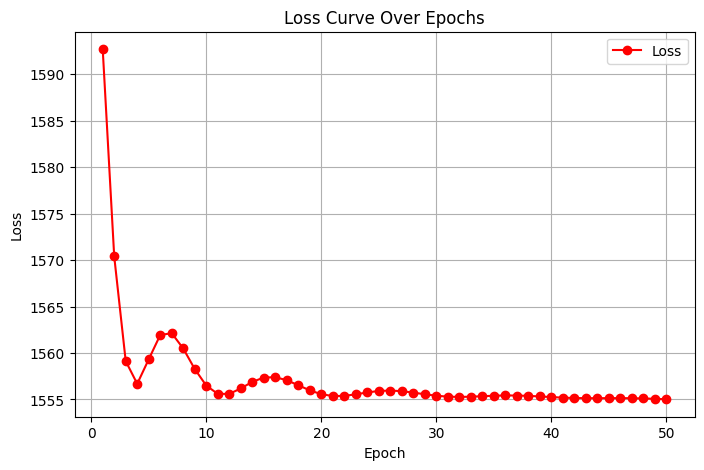

In [ ]:
# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='r', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Over Epochs")
plt.legend()
plt.grid()
plt.show()

Plot the solution after every training epoch

###Convert entire pipeline into a single script

In [ ]:
%%writefile heat_equation_solver.py
#Make imports
import os
import torch
import torch.nn as nn
import torch.optim  # Used for optimizer
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation  # Used for animation
from typing import Callable
import tqdm
import pickle
class HeatEquationSolver:
  def __init__(self,
               nx:int,
               ny:int,
               x_range:tuple,
               y_range:tuple,
               device:str): #can put 'cuda' to use gpu if gpu available, if gpu not available, by default cpu will be used irrespective of what is mentioned as device
    self.nx=nx
    self.ny=ny
    self.x_range=x_range
    self.y_range=y_range
    self.device=device if torch.cuda.is_available() else 'cpu'
    print('Instance of Class HeatEquationSolver made, call make_imports method to get all required libraries')

  def make_grid(self):

    '''Takes no input only makes
       a mesh grid from instance
       attributes.
    '''
    #Make linear space of x and y and reshape to the shape(nx,1) and (ny,1) respectively (Reshaping is done so that in case of matrix multiplication or broadcasting no error is encountered)
    x = torch.linspace(self.x_range[0], self.x_range[1], self.nx).reshape(-1, 1)
    y = torch.linspace(self.y_range[0], self.y_range[1], self.ny).reshape(-1, 1)

    #Make meshgrid
    X,Y=torch.meshgrid(x.squeeze(),y.squeeze(),indexing='ij')
    X=X.reshape(self.nx,self.ny).requires_grad_(True)
    Y=Y.reshape(self.nx,self.ny).requires_grad_(True)

    #Send data to selected device and assign X,Y
    self.X=X.to(self.device)
    self.Y=Y.to(self.device)

    #return X and Y
    return self.X,self.Y

  def save_checkpoint(self, model, optimizer, loss, model_name, hyperparameters):
    '''Checkpoints model with best loss value'''
    self.checkpoint_dir = f"checkpoint_{model_name}_nx{self.nx}_ny{self.ny}_epochs{hyperparameters['epochs']}"
    os.makedirs(self.checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(self.checkpoint_dir, "model_checkpoint.pkl")

    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
        "hyperparameters": hyperparameters
    }
    # Saving the checkpoint to the file
    torch.save(checkpoint, checkpoint_path)
  def train_step(self,
                 model:nn.Module,
                 X:torch.Tensor,
                 Y:torch.Tensor,
                 loss_fn:Callable,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None):
    '''Performs one epoch of training process.
    If calling this function explicitly, make
    sure model and optimizer are in the same
    device as tensors. Do not use loss functions
    with learnable parameters, if used manually
    make sure they are stored in correct device'''

    #Forward Pass
    prediction=model(X,Y,self.nx,self.ny)
    #Calculate Loss
    loss=loss_fn(model=model, x=X,y=Y, nx=self.nx,ny=self.ny)
    #Set Optimizer Zero Grad
    optimizer.zero_grad()
    #Backward pass
    loss.backward()
    #Optimizer Step
    optimizer.step()
    #scheduler step
    if scheduler:
      try:
          scheduler.step()
      except TypeError: #To handle both types of schedulers
          scheduler.step(loss.item())
    return  X, Y, prediction, loss.item(), model.state_dict()


  def train(self, model, loss_fn, optimizer, epochs, model_name, animate_training=False, get_loss_curve=False, scheduler=None):
    try:
        X, Y = self.X, self.Y
        X.requires_grad_(True)
        Y.requires_grad_(True)
        model = model.to(self.device)
        best_loss = float('inf')

        loss_values = []
        frames = []
        plt.ioff()#Switching off plt interative mode
        '''Training Loop'''
        for epoch in tqdm.tqdm(range(epochs)):
          X, Y, Z, loss, model_params = self.train_step(model, X, Y, loss_fn, optimizer, scheduler)
          loss_values.append(loss)
          '''Checkpointing'''
          if loss < best_loss:
              best_loss = loss
              self.save_checkpoint(model, optimizer, loss, model_name, {"epochs": epochs})
          '''Saving frames for animation'''
          if animate_training:
              frames.append((X.detach().cpu().numpy().copy(), Y.detach().cpu().numpy().copy(), Z.detach().cpu().numpy().copy(), epoch))

        print(f"Best Loss Achieved: {best_loss}")
        '''Plot Loss Curve'''
        if get_loss_curve:
          print(f"Plotting Loss Curve")
          plt.figure(figsize=(8, 5))
          plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='r', label="Loss")
          plt.xlabel("Epoch")
          plt.ylabel("Loss")
          plt.title("Loss Curve Over Epochs")
          plt.legend()
          plt.grid()
          loss_curve_path = os.path.join(self.checkpoint_dir, "loss_curve.png")
          plt.savefig(loss_curve_path)
          print(f"Loss curve saved at {loss_curve_path}")
          plt.show()

        '''Animate Training Process'''
        if animate_training:
          print(f"Animating the training process")
          fig = plt.figure(figsize=(8, 6))
          ax = fig.add_subplot(111, projection='3d')

          def update(frame_idx):
            X_np, Y_np, Z_np, epoch = frames[frame_idx]
            ax.cla()
            ax.plot_surface(X_np, Y_np, Z_np, cmap='viridis')
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.set_zlabel("T")
            ax.set_title(f"Epoch: {epoch+1}")

          ani = FuncAnimation(fig, update, frames=len(frames), interval=500)
          animation_path = os.path.join(f"checkpoint_{model_name}_nx{self.nx}_ny{self.ny}_epochs{epochs}", "training_animation.gif")
          fps = max(1, len(frames) // 15) #Setting fps so that animation ends in 15 seconds irrespective of number of frames
          ani.save(animation_path, writer="pillow", fps=fps)
          print(f"Animation saved at {animation_path}")

        return Z, loss_values
    except AttributeError:
        print("Make grid first, Call make_grid method")
  def load_and_evaluate_model(self, model_class, checkpoint_path):
    """
    Loads a model from a saved checkpoint, evaluates it on X, Y, and plots a 3D graph.

    Args:
        model_class (type): The model class (e.g., MyModel, not a string).
        checkpoint_path (str): Path to the saved model checkpoint (.pkl file).
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=self.device)

    # Create an instance of the provided model class
    model = model_class().to(self.device)

    # Load model parameters
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Evaluate model on grid
    with torch.no_grad():
        Z = model(self.X, self.Y, self.nx, self.ny)

    # Plot the results
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(self.X.detach().cpu().numpy(), self.Y.detach().cpu().numpy(), Z.detach().cpu().numpy(), cmap="viridis")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("T")
    ax.set_title("Predicted Heat Distribution")
    plt.show()



Overwriting heat_equation_solver.py


Run the script

Using above script, the entire process can be run using the methods in the HeatEquationSolver Class once the neural network, loss function and optimizer is defined by the user

Tried 3 different types of neural networks
1. MLP
2. Fourier Neural Operator
3. DeepRitz Inspired Model
On training the 3 models separately for similar number of epochs, DeepRitz performed the best, so I removed all others. Will try to finetune the DeepRitz model.

Deep Ritz Method Inspired Network

100%|██████████| 500/500 [24:13<00:00,  2.91s/it]


Best Loss Achieved: 0.31221476197242737
Plotting Loss Curve
Loss curve saved at checkpoint_DeepRitz_nx250_ny250_epochs500/loss_curve.png


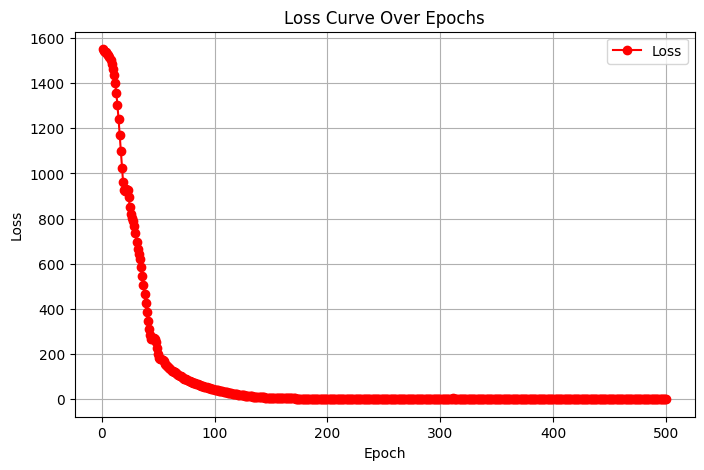

Animating the training process
Animation saved at checkpoint_DeepRitz_nx250_ny250_epochs500/training_animation.gif


In [ ]:
import heat_equation_solver
from heat_equation_solver import HeatEquationSolver
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim  # Used for optimizer
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation  # Used for animation
from typing import Callable
import os
import tqdm
from IPython.display import display, Image

class DeepRitz_SolutionFunction(nn.Module):
    def __init__(self, hidden_dim=50, num_layers=6):
        super().__init__()
        self.input_layer = nn.Linear(2, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, X, Y, nx, ny):
        X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
        x = torch.cat((X, Y), dim=1)
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x)) + x  # Residual connection

        return self.output_layer(x).reshape(nx, ny)
model=DeepRitz_SolutionFunction()

'''Defining Loss function'''
def loss_fn(model:nn.Module,
            x:torch.Tensor,
            y:torch.Tensor,
            nx:int,
            ny:int,
            boundary_loss_weight:float=2.0):

  prediction=model(x,y,nx,ny)
  #Calculate gradients
  f_x=torch.autograd.grad(prediction,x,torch.ones_like(prediction),create_graph=True)[0]
  f_y=torch.autograd.grad(prediction,y,torch.ones_like(prediction),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=8*torch.pi**2*torch.sin(2*torch.pi*x)*torch.sin(2*torch.pi*y)

  #Calculate pde loss
  pde_loss=torch.mean((f_xx+f_yy-target)**2)

  #get boundary loss
  boundary_loss=((prediction[0,:]-torch.zeros(prediction.shape[-1]))**2+ (prediction[-1,:]-torch.zeros(prediction.shape[-1]))**2+ (prediction[:,0]-torch.zeros(prediction.shape[-1]))**2+ (prediction[:,-1]-torch.zeros(prediction.shape[-1]))**2).mean()

  return pde_loss+(boundary_loss_weight*boundary_loss)



'''Set Optimizer'''
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

'''Make solver instance'''
current_solver=HeatEquationSolver(nx=250,ny=250,x_range=(0,1),y_range=(0,1),device='cpu')

'''Make Grid'''
X,Y=current_solver.make_grid()

'''Train'''
Z=current_solver.train(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=500,#This model is learning well enough in around 400-500 epochs
                     model_name='DeepRitz',
                     animate_training=True,
                     get_loss_curve=True)

#display(Image(filename='checkpoint_MLP_1_nx250_ny250_epochs10/training_animation.gif'))

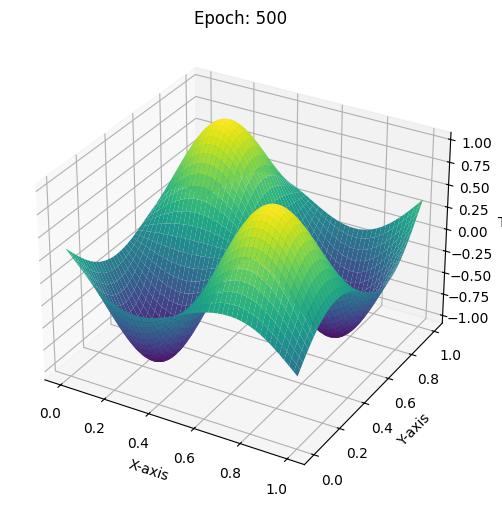

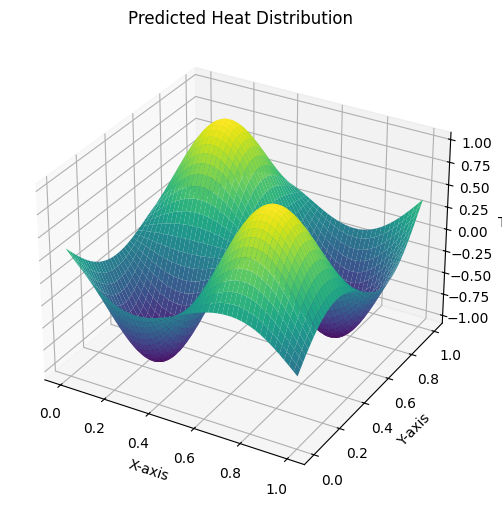

In [ ]:
current_solver.load_and_evaluate_model(model_class=DeepRitz_SolutionFunction,checkpoint_path="/content/checkpoint_DeepRitz_nx250_ny250_epochs500/model_checkpoint.pkl")

The DeepRitz model seems to be training in the best possible manner, so will move forward with that one.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Instance of Class HeatEquationSolver made, call make_imports method to get all required libraries


100%|██████████| 850/850 [34:50<00:00,  2.46s/it]


Best Loss Achieved: 0.26377612352371216
Plotting Loss Curve
Loss curve saved at checkpoint_DeepRitz_nx250_ny250_epochs850/loss_curve.png


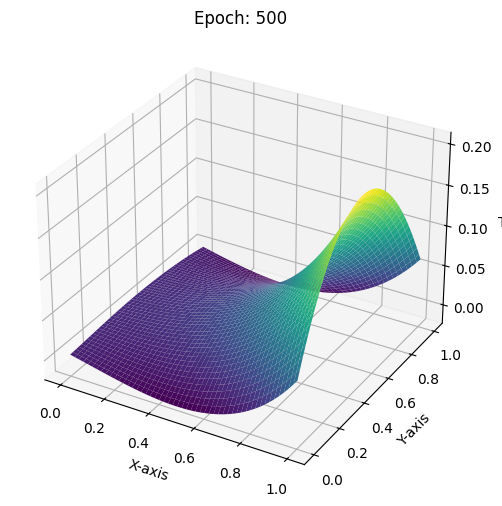

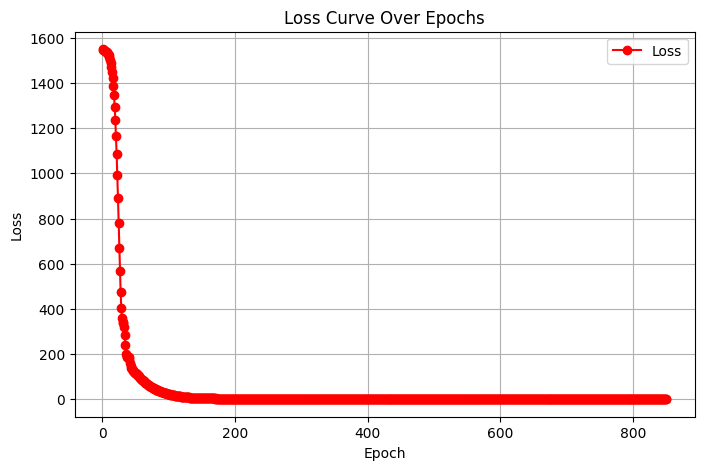

Animating the training process
Animation saved at checkpoint_DeepRitz_nx250_ny250_epochs850/training_animation.gif


In [ ]:
import heat_equation_solver
from heat_equation_solver import HeatEquationSolver
import torch
import torch.nn as nn
class DeepRitz_SolutionFunction(nn.Module):
    def __init__(self, hidden_dim=50, num_layers=6):
        super().__init__()
        self.input_layer = nn.Linear(2, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, X, Y, nx, ny):
        X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
        x = torch.cat((X, Y), dim=1)
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x)) + x  # Residual connection

        return self.output_layer(x).reshape(nx, ny)
model=DeepRitz_SolutionFunction()

'''Defining Loss function'''
def loss_fn(model:nn.Module,
            x:torch.Tensor,
            y:torch.Tensor,
            nx:int,
            ny:int,
            boundary_loss_weight:float=2.0):

  prediction=model(x,y,nx,ny)
  #Calculate gradients
  f_x=torch.autograd.grad(prediction,x,torch.ones_like(prediction),create_graph=True)[0]
  f_y=torch.autograd.grad(prediction,y,torch.ones_like(prediction),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=8*torch.pi**2*torch.sin(2*torch.pi*x)*torch.sin(2*torch.pi*y)

  #Calculate pde loss
  pde_loss=torch.mean((f_xx+f_yy-target)**2)

  #get boundary loss
  boundary_loss=((prediction[0,:]-torch.zeros(prediction.shape[-1]))**2+ (prediction[-1,:]-torch.zeros(prediction.shape[-1]))**2+ (prediction[:,0]-torch.zeros(prediction.shape[-1]))**2+ (prediction[:,-1]-torch.zeros(prediction.shape[-1]))**2).mean()

  return pde_loss+(boundary_loss_weight*boundary_loss)



'''Set Optimizer'''
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

'''Add Scheduler'''
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

'''Make solver instance'''
current_solver=HeatEquationSolver(nx=250,ny=250,x_range=(0,1),y_range=(0,1),device='cpu')


'''Make Grid'''
X,Y=current_solver.make_grid()

'''Train'''
Z=current_solver.train(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=850,#This model is learning well enough in around 400-500 epochs
                     model_name='DeepRitz',
                     animate_training=True,
                     get_loss_curve=True,
                     scheduler=scheduler)

#image immediately below may be showing model of a different example altogether, refer to training animation to view correct one.

/content/heat_equation_solver.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=self.device)


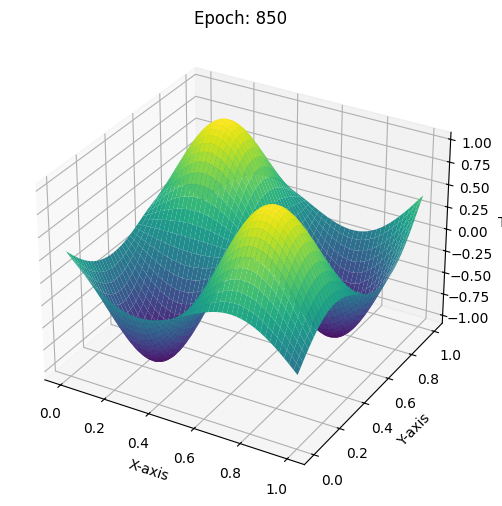

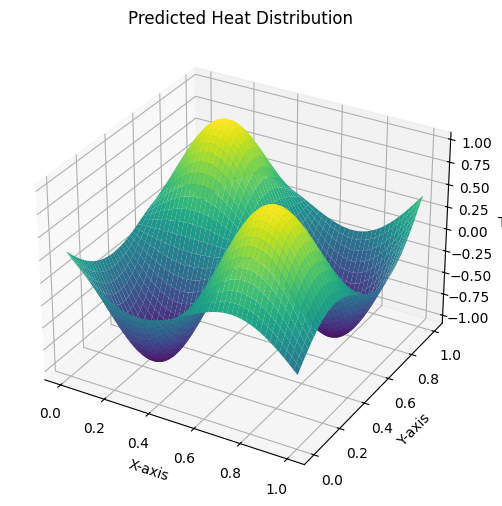

In [ ]:
current_solver.load_and_evaluate_model(model_class=DeepRitz_SolutionFunction,checkpoint_path="/content/checkpoint_DeepRitz_nx250_ny250_epochs850/model_checkpoint.pkl")

##Example 2
Heat Equation: ∂²T/∂x² + ∂²T/∂y² = 0

Boundary Conditions:
T(0,y) = 0
T(1,y) = 0
T(x,0) = 0
T(x,1) = sin(πx)


Instance of Class HeatEquationSolver made, call make_imports method to get all required libraries


100%|██████████| 500/500 [20:44<00:00,  2.49s/it]


Best Loss Achieved: 0.004625117406249046
Plotting Loss Curve
Loss curve saved at checkpoint_DeepRitz_nx250_ny250_epochs500/loss_curve.png


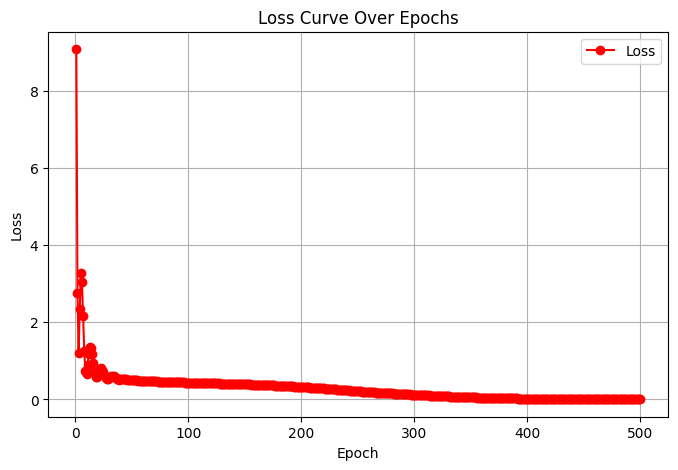

Animating the training process
Animation saved at checkpoint_DeepRitz_nx250_ny250_epochs500/training_animation.gif


In [ ]:
import heat_equation_solver
from heat_equation_solver import HeatEquationSolver
import torch
import torch.nn as nn
class DeepRitz_SolutionFunction(nn.Module):
    def __init__(self, hidden_dim=50, num_layers=6):
        super().__init__()
        self.input_layer = nn.Linear(2, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, X, Y, nx, ny):
        X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
        x = torch.cat((X, Y), dim=1)
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x)) + x  # Residual connection

        return self.output_layer(x).reshape(nx, ny)
model=DeepRitz_SolutionFunction()

'''Defining Loss function'''
def loss_fn(model:nn.Module,
            x:torch.Tensor,
            y:torch.Tensor,
            nx:int,
            ny:int,
            boundary_loss_weight:float=2.0):

  prediction=model(x,y,nx,ny)
  #Calculate gradients
  f_x=torch.autograd.grad(prediction,x,torch.ones_like(prediction),create_graph=True)[0]
  f_y=torch.autograd.grad(prediction,y,torch.ones_like(prediction),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=torch.zeros_like(prediction)

  #Calculate pde loss
  pde_loss=torch.mean((f_xx+f_yy-target)**2)

  #get boundary loss
  boundary_loss=((prediction[0,:]-torch.zeros(prediction.shape[-1]))**2+ #T(0,y)=0
                 (prediction[-1,:]-torch.zeros(prediction.shape[-1]))**2+#T(1,y)=0
                 (prediction[:,0]-torch.zeros(prediction.shape[-1]))**2+#T(x,0)=0
                 (prediction[:,-1]-torch.sin(torch.pi * x[:, -1]))**2).mean()#T(x,1)=sin(pi*x)

  return pde_loss+(boundary_loss_weight*boundary_loss)



'''Set Optimizer'''
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

'''Add Scheduler'''
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

'''Make solver instance'''
current_solver=HeatEquationSolver(nx=250,ny=250,x_range=(0,1),y_range=(0,1),device='cpu')


'''Make Grid'''
X,Y=current_solver.make_grid()

'''Train'''
Z=current_solver.train(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=500,#This model is learning well enough in around 400-500 epochs
                     model_name='DeepRitz',
                     animate_training=True,
                     get_loss_curve=True,
                     scheduler=None)

#display(Image(filename='checkpoint_MLP_1_nx250_ny250_epochs10/training_animation.gif'))

##Example 3
Heat Equation: ∂²T/∂x² + ∂²T/∂y² = 0

Boundary Conditions:
T(0,y) = 0
T(1,y) = y(1-y)
T(x,0) = 0
T(x,1) = 0


Instance of Class HeatEquationSolver made, call make_imports method to get all required libraries


100%|██████████| 500/500 [20:23<00:00,  2.45s/it]


Best Loss Achieved: 0.004507981240749359
Plotting Loss Curve
Loss curve saved at checkpoint_DeepRitz_nx250_ny250_epochs500/loss_curve.png


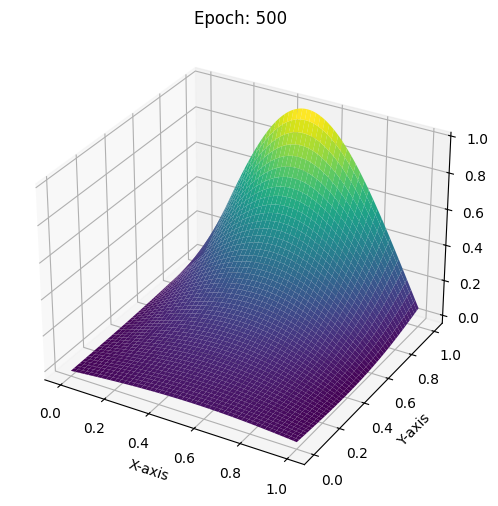

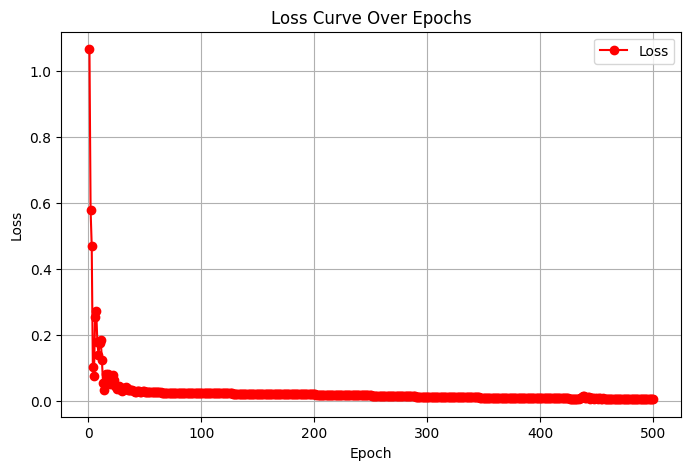

Animating the training process
Animation saved at checkpoint_DeepRitz_nx250_ny250_epochs500/training_animation.gif


In [ ]:
import heat_equation_solver
from heat_equation_solver import HeatEquationSolver
import torch
import torch.nn as nn
class DeepRitz_SolutionFunction(nn.Module):
    def __init__(self, hidden_dim=50, num_layers=6):
        super().__init__()
        self.input_layer = nn.Linear(2, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, X, Y, nx, ny):
        X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
        x = torch.cat((X, Y), dim=1)
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x)) + x  # Residual connection

        return self.output_layer(x).reshape(nx, ny)
model=DeepRitz_SolutionFunction()

'''Defining Loss function'''
def loss_fn(model:nn.Module,
            x:torch.Tensor,
            y:torch.Tensor,
            nx:int,
            ny:int,
            boundary_loss_weight:float=2.0):

  prediction=model(x,y,nx,ny)
  #Calculate gradients
  f_x=torch.autograd.grad(prediction,x,torch.ones_like(prediction),create_graph=True)[0]
  f_y=torch.autograd.grad(prediction,y,torch.ones_like(prediction),create_graph=True)[0]

  #Calculate second order gradients
  f_xx=torch.autograd.grad(f_x,x,torch.ones_like(f_x),create_graph=True)[0]
  f_yy=torch.autograd.grad(f_y,y,torch.ones_like(f_y),create_graph=True)[0]

  #Calculate target value of function
  target=torch.zeros_like(prediction)

  #Calculate pde loss
  pde_loss=torch.mean((f_xx+f_yy-target)**2)

  #get boundary loss
  boundary_loss=((prediction[0,:]-torch.zeros(prediction.shape[-1]))**2+ #T(0,y)=0
                 (prediction[-1, :] - (y[-1, :] * (1 - y[-1, :])))**2+#T(1,y)=y(1-y)
                 (prediction[:,0]-torch.zeros(prediction.shape[-1]))**2+#T(x,0)=0
                 (prediction[:, -1] - torch.zeros_like(prediction[:, -1]))**2).mean()#T(x,1)=0

  return pde_loss+(boundary_loss_weight*boundary_loss)



'''Set Optimizer'''
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

'''Add Scheduler'''
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

'''Make solver instance'''
current_solver=HeatEquationSolver(nx=250,ny=250,x_range=(0,1),y_range=(0,1),device='cpu')


'''Make Grid'''
X,Y=current_solver.make_grid()

'''Train'''
Z=current_solver.train(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=500,#This model is learning well enough in around 400-500 epochs
                     model_name='DeepRitz',
                     animate_training=True,
                     get_loss_curve=True,
                     scheduler=None)

#display(Image(filename='checkpoint_MLP_1_nx250_ny250_epochs10/training_animation.gif'))

##Example 4 (Time Dependent)
Heat Equation: ∂T/∂t = α(∂²T/∂x² + ∂²T/∂y²)

Initial Conditions:
T(x,y,0) = sin(πx)sin(πy)
T(0,y,t) = 0
T(1,y,t) = 0
T(x,0,t) = 0
T(x,1,t) = 0
α = 0.01


In [ ]:
%%writefile time_dependent_heat_equation.py
import os
import torch
import torch.nn as nn
import torch.optim  # Used for optimizer
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter  # Used for animation
from typing import Callable
import tqdm
import pickle

class TimeDependentHeatEquationSolver:
  def __init__(self,
               nx:int,
               ny:int,
               nt:int,
               x_range:tuple,
               y_range:tuple,
               t_range:tuple,
               device:str): #can put 'cuda' to use gpu if gpu available, if gpu not available, by default cpu will be used irrespective of what is mentioned as device
    self.nx=nx
    self.ny=ny
    self.nt=nt
    self.x_range=x_range
    self.y_range=y_range
    self.t_range=t_range
    self.device=device if torch.cuda.is_available() else 'cpu'
    self.model_checkpoint_path = None
    print('Instance of Class TimeDependentHeatEquationSolver made.')

  def make_grid(self):
    x = torch.linspace(self.x_range[0], self.x_range[1], self.nx).reshape(-1, 1)
    y = torch.linspace(self.y_range[0], self.y_range[1], self.ny).reshape(-1, 1)
    t = torch.linspace(self.t_range[0], self.t_range[1], self.nt).reshape(-1, 1)
    X,Y,T = torch.meshgrid(x.squeeze(), y.squeeze(), t.squeeze(), indexing='ij')
    X=X.requires_grad_(True)
    Y=Y.requires_grad_(True)
    T=T.requires_grad_(True)
    self.X=X.to(self.device)
    self.Y=Y.to(self.device)
    self.T=T.to(self.device)
    return self.X,self.Y,self.T

  def save_checkpoint(self, model, optimizer, loss, model_name, hyperparameters):
    self.checkpoint_dir = f"checkpoint_{model_name}_nx{self.nx}_ny{self.ny}_nt{self.nt}_epochs{hyperparameters['epochs']}"
    os.makedirs(self.checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(self.checkpoint_dir, "model_checkpoint.pkl")
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
        "hyperparameters": hyperparameters
    }
    torch.save(checkpoint, checkpoint_path)
    self.model_checkpoint_path = checkpoint_path

  def train_step(self, model: nn.Module, X: torch.Tensor, Y: torch.Tensor, T: torch.Tensor, loss_fn: Callable, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler = None):
      '''Performs one epoch of training process.
      If calling this function explicitly, make
      sure model and optimizer are in the same
      device as tensors. Do not use loss functions
      with learnable parameters, if used manually
      make sure they are stored in correct device'''

      # Forward Pass
      prediction = model(X, Y, T, self.nx, self.ny, self.nt)
      # Calculate Loss
      loss = loss_fn(model=model, x=X, y=Y, t=T, nx=self.nx, ny=self.ny, nt=self.nt)
      # Set Optimizer Zero Grad
      optimizer.zero_grad()
      # Backward pass
      loss.backward()
      # Optimizer Step
      optimizer.step()
      # Scheduler step
      if scheduler:
          try:
              scheduler.step()
          except TypeError:  # To handle both types of schedulers
              scheduler.step(loss.item())
      return X, Y, T, prediction, loss.item(), model.state_dict()

  def train(self, model, loss_fn, optimizer, epochs, model_name, get_loss_curve=False, scheduler=None):
    try:
        X, Y, T = self.X, self.Y, self.T
        X.requires_grad_(True)
        Y.requires_grad_(True)
        T.requires_grad_(True)
        model = model.to(self.device)
        best_loss = float('inf')

        loss_values = []
        plt.ioff()
        for epoch in tqdm.tqdm(range(epochs)):
          X, Y, T, Z, loss, model_params = self.train_step(model, X, Y, T, loss_fn, optimizer, scheduler)
          loss_values.append(loss)
          if loss < best_loss:
              best_loss = loss
              self.save_checkpoint(model, optimizer, loss, model_name, {"epochs": epochs})

        print(f"Best Loss Achieved: {best_loss}")
        if get_loss_curve:
          plt.figure(figsize=(8, 5))
          plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='r', label="Loss")
          plt.xlabel("Epoch")
          plt.ylabel("Loss")
          plt.title("Loss Curve Over Epochs")
          plt.legend()
          plt.grid()
          loss_curve_path = os.path.join(self.checkpoint_dir, "loss_curve.png")
          plt.savefig(loss_curve_path)
          print(f"Loss curve saved at {loss_curve_path}")
          plt.show()

        return self.model_checkpoint_path
    except AttributeError:
        print("Make grid first, Call make_grid method")

  def animate_final_prediction(self, model_class, model_checkpoint_path=None):
    try:
        if model_checkpoint_path is None:
            if self.model_checkpoint_path is None:
                raise AttributeError("Model checkpoint not found. Please train the model first by calling the train function.")
            model_checkpoint_path = self.model_checkpoint_path

        checkpoint = torch.load(model_checkpoint_path, map_location=self.device)
        model = model_class().to(self.device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")

        with torch.no_grad():
          Z_all = model(self.X, self.Y, self.T, self.nx, self.ny, self.nt)  # Compute for all time steps

        def update(frame):
          '''This function clears the graph,
             evaluates the model prediciton
             for a particular time, and plots
             the surface, then, plots the axes.'''
          ax.clear()

          ax.plot_surface(self.X.detach().cpu().numpy()[:,:,frame], self.Y.detach().cpu().numpy()[:,:,frame], Z_all.detach().cpu().numpy()[:,:,frame], cmap="viridis")
          ax.set_xlabel("X-axis")
          ax.set_ylabel("Y-axis")
          ax.set_zlabel("T")
          ax.set_title(f"Predicted Heat Distribution at Time {frame}")

        ani = FuncAnimation(fig, update, frames=self.nt, repeat=False)
        # Ensure checkpoint directory exists
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Define file path and save animation
        animation_path = os.path.join(self.checkpoint_dir, "heat_distribution.gif")
        ani.save(animation_path, writer=PillowWriter(fps=10))

        # Store path in self.model_checkpoint_path
        self.model_checkpoint_path = animation_path
        print(f"Animation saved at: {animation_path}")

        # Close figure to free memory
        plt.close(fig)

        plt.show()
    except AttributeError as e:
        print(e)


Overwriting time_dependent_heat_equation.py


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Instance of Class TimeDependentHeatEquationSolver made.


100%|██████████| 5/5 [00:55<00:00, 11.09s/it]


Best Loss Achieved: 0.38383060693740845
Loss curve saved at checkpoint_DeepRitz_TimeDependent_nx30_ny30_nt30_epochs5/loss_curve.png


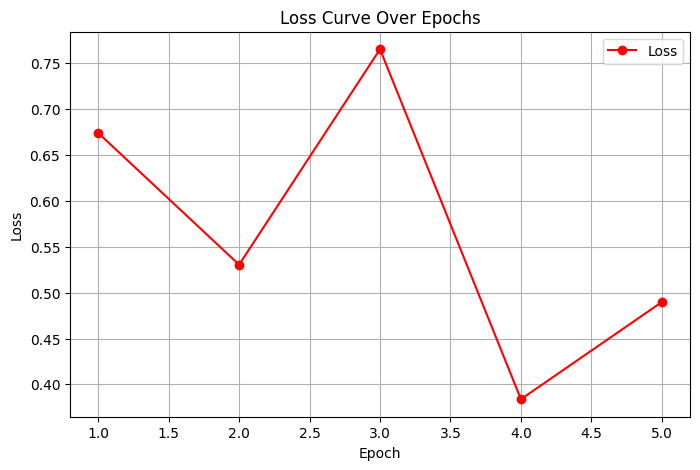

In [ ]:
import time_dependent_heat_equation
from time_dependent_heat_equation import TimeDependentHeatEquationSolver
import torch
import torch.nn as nn

class DeepRitzSolutionFunction(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=8, use_fourier=True):
        super().__init__()
        self.use_fourier = use_fourier

        self.input_layer = nn.Linear(hidden_dim if use_fourier else input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

        if use_fourier:
            self.freq_embedding = nn.Linear(input_dim, hidden_dim)
            torch.nn.init.normal_(self.freq_embedding.weight, mean=0, std=1)

    def forward(self, X, Y, T, nx, ny, nt):
        X, Y, T = X.reshape(-1, 1), Y.reshape(-1, 1), T.reshape(-1, 1)
        inputs = torch.cat((X, Y, T), dim=1)

        if self.use_fourier:
            inputs = torch.sin(self.freq_embedding(inputs))

        x = self.activation(self.input_layer(inputs))  # Now input matches dimensions

        for layer in self.hidden_layers:
            residual = x
            x = self.activation(layer(x)) + residual

        return self.output_layer(x).view(nx,ny,nt)  # Ensure return value has the correct shape

model = DeepRitzSolutionFunction()

'''Defining Loss function'''
def loss_fn(model: nn.Module, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor,
            nx: int, ny: int, nt:int, alpha: float = 0.01,
            boundary_loss_weight: float = 2.0,
            initial_loss_weight: float = 2.0):

    prediction = model(x, y, t, nx, ny, nt)

    # Compute first-order gradients
    f_x = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
    f_y = torch.autograd.grad(prediction, y, torch.ones_like(prediction), create_graph=True)[0]
    f_t = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0]

    # Compute second-order gradients
    f_xx = torch.autograd.grad(f_x, x, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y, torch.ones_like(f_y), create_graph=True)[0]

    # Heat equation: u_t = alpha * (u_xx + u_yy)
    pde_loss = torch.mean((f_t - alpha * (f_xx + f_yy))**2)

    # Boundary conditions
    boundary_loss = (
        (prediction[0, :, :] - torch.zeros_like(prediction[0, :, :]))**2 +
        (prediction[-1, :, :] - torch.zeros_like(prediction[-1, :, :]))**2 +
        (prediction[:, 0, :] - torch.zeros_like(prediction[:, 0, :]))**2 +
        (prediction[:, -1, :] - torch.zeros_like(prediction[:, -1, :]))**2
    ).mean()

    # Initial condition loss (at t=0, should match given initial condition u_0(x,y))
    initial_condition = torch.sin(torch.pi * x[:,:,0]) * torch.sin(torch.pi * y[:,:,0])
    initial_condition_loss = torch.mean((prediction[:, :, 0] - initial_condition) ** 2)

    total_loss = pde_loss + (boundary_loss_weight * boundary_loss) + (initial_loss_weight * initial_condition_loss)
    return total_loss

'''Set Optimizer'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

'''Add Scheduler'''
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

'''Make solver instance'''
current_solver = TimeDependentHeatEquationSolver(nx=30, ny=30, nt=30, x_range=(0, 1), y_range=(0, 1), t_range=(0, 1), device='cpu')

'''Make Grid'''
X, Y, T = current_solver.make_grid()

'''Train'''
Z = current_solver.train(model=model,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=5,
                         model_name='DeepRitz_TimeDependent',
                         get_loss_curve=True,
                         scheduler=scheduler)

In [ ]:
'''Animate Trained Model'''
current_solver.animate_final_prediction(model_class=DeepRitzSolutionFunction)

/content/time_dependent_heat_equation.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location=self.device)


Animation saved at: checkpoint_DeepRitz_TimeDependent_nx30_ny30_nt30_epochs5/heat_distribution.gif
